# Model Exploration
* This notebook is broken into two sections; Pre-Campaign Modeling and Post-Campaign modeling.
* The first section trains models using pre-campaign features of the dataset (demographic data) and then uses the whole dataset to try and predict which customers are likely to subscribe to a term deposit product so as to save call time for call center employees 
* The second section looks at the dataset as a whole to minimize the call time even more as well as looking at the customers that call center employees should prioritize and what ulitmately makes those customers subscribe.

In [2]:
import pandas as pd
import pycaret
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
df_ = pd.read_parquet('Data/model-ready-term-deposit-marketing-2020.parquet')
df_.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,y,duration_in_minutes
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,0,4.350000
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,0,2.516667
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,0,1.266667
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,1,0,1.533333
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,1,0,3.300000


In [4]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  40000 non-null  int64   
 1   job                  40000 non-null  category
 2   marital              40000 non-null  category
 3   education            40000 non-null  category
 4   default              40000 non-null  int32   
 5   balance              40000 non-null  int64   
 6   housing              40000 non-null  int32   
 7   loan                 40000 non-null  int32   
 8   contact              40000 non-null  category
 9   day                  40000 non-null  int64   
 10  month                40000 non-null  category
 11  campaign             40000 non-null  int64   
 12  y                    40000 non-null  int32   
 13  duration_in_minutes  40000 non-null  float64 
dtypes: category(5), float64(1), int32(4), int64(4)
memory usage: 2.3 MB


In [5]:
target_variable = df_['y']

X = df_.drop(columns='y', axis=1)

X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,duration_in_minutes
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,4.350000
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,2.516667
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,1.266667
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,1,1.533333
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,1,3.300000


## Pre-Campaign Modeling
* Looking at the first 8 columns of features this section looks at obtaining the highest recall score for class 1
* Pycaret will be used to look for optimal models to look at more closely
* RandomizedSearch and Optuna will be used for hyperparameter tuning
* For reproducability purposes, use seed=3046

In [6]:
pre_campaign_df = X.iloc[:, 0:8]
pre_campaign_df.head()

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,0,2143,1,0
1,44,technician,single,secondary,0,29,1,0
2,33,entrepreneur,married,secondary,0,2,1,1
3,47,blue-collar,married,unknown,0,1506,1,0
4,33,unknown,single,unknown,0,1,0,0


In [7]:
num_features = [col for col in pre_campaign_df.columns if X[col].dtype != 'category']
print(f"Numerical features:   {num_features}")
categ_features = [col for col in pre_campaign_df.columns if X[col].dtype == 'category']
print(f"Categorical features: {categ_features}")

Numerical features:   ['age', 'default', 'balance', 'housing', 'loan']
Categorical features: ['job', 'marital', 'education']


In [8]:
seed = 3046

In [9]:
from pycaret.classification import *
import random

# seed = random.randint(1000, 9999)

imbalance_methods = ['randomoversampler', 'smotetomek', 'smoteenn']
n_select = 5
imbalance_type_dict = {}


for type in imbalance_methods:
  print(f'Type of imbalance technique: {type}')
  s = setup(data=pre_campaign_df,
        target=target_variable, 
        session_id=seed, 
        train_size=.80, 
        fix_imbalance=True, 
        fix_imbalance_method=type,
        categorical_features=categ_features
      )
  # print(s.X_train)
  print()
  best_models = compare_models(sort='Recall', n_select=n_select)
  results = pull()
  # print(best_models)

  model_recall_score_dict = {}

  for i in range(n_select):
      model_recall_score_dict[results.index[i]] = results.iloc[i].Recall

  imbalance_type_dict[type] = model_recall_score_dict

  print(imbalance_type_dict)

  # evaluation = [evaluate_model(estimator=model) for model in best_models]
  print('-'*50)


Type of imbalance technique: randomoversampler


,Description,Value
0,Session id,8867
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 9)"
4,Transformed data shape,"(67366, 25)"
5,Transformed train set shape,"(59366, 25)"
6,Transformed test set shape,"(8000, 25)"
7,Numeric features,5
8,Categorical features,3
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.3618,0.5553,0.7231,0.0749,0.1295,0.0073,0.0372,0.7350
nb,Naive Bayes,0.5727,0.5957,0.5745,0.0950,0.1630,0.0442,0.0768,0.2670
lr,Logistic Regression,0.5928,0.6077,0.5671,0.0985,0.1679,0.0508,0.0851,3.1440
ridge,Ridge Classifier,0.5929,0.6073,0.5654,0.0984,0.1675,0.0504,0.0844,0.3190
lda,Linear Discriminant Analysis,0.5930,0.6073,0.5654,0.0984,0.1676,0.0504,0.0844,0.1790
ada,Ada Boost Classifier,0.6177,0.6234,0.5468,0.1018,0.1716,0.0565,0.0904,1.1260
gbc,Gradient Boosting Classifier,0.6443,0.6243,0.5192,0.1051,0.1747,0.0617,0.0938,2.2210
lightgbm,Light Gradient Boosting Machine,0.6901,0.6082,0.4467,0.1072,0.1728,0.0634,0.0880,0.5770
qda,Quadratic Discriminant Analysis,0.5923,0.5134,0.4237,0.0872,0.1231,0.0186,0.0222,0.4980
xgboost,Extreme Gradient Boosting,0.7400,0.5822,0.3431,0.1048,0.1605,0.0557,0.0696,0.3100


{'randomoversampler': {'svm': 0.7231, 'nb': 0.5745, 'lr': 0.5671, 'ridge': 0.5654, 'lda': 0.5654}}
--------------------------------------------------
Type of imbalance technique: smotetomek


,Description,Value
0,Session id,8867
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 9)"
4,Transformed data shape,"(65538, 25)"
5,Transformed train set shape,"(57538, 25)"
6,Transformed test set shape,"(8000, 25)"
7,Numeric features,5
8,Categorical features,3
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.3554,0.5430,0.7202,0.0732,0.1273,0.0047,0.0308,4.9120
nb,Naive Bayes,0.4664,0.5755,0.6435,0.0840,0.1486,0.0236,0.0501,5.4220
ridge,Ridge Classifier,0.5900,0.6060,0.5667,0.0979,0.1669,0.0495,0.0833,4.6590
lda,Linear Discriminant Analysis,0.5900,0.6060,0.5667,0.0979,0.1669,0.0495,0.0833,5.7460
lr,Logistic Regression,0.5902,0.6066,0.5654,0.0977,0.1666,0.0492,0.0828,6.8200
knn,K Neighbors Classifier,0.6493,0.5386,0.3954,0.0853,0.1403,0.0241,0.0354,6.6260
dt,Decision Tree Classifier,0.8640,0.5240,0.1312,0.1148,0.1224,0.0491,0.0492,4.9610
et,Extra Trees Classifier,0.8922,0.5612,0.0919,0.1368,0.1099,0.0549,0.0561,6.1750
rf,Random Forest Classifier,0.9086,0.5742,0.0751,0.1840,0.1065,0.0670,0.0748,5.9670
qda,Quadratic Discriminant Analysis,0.8699,0.4800,0.0708,0.0859,0.0603,0.0055,0.0066,5.8220


{'randomoversampler': {'svm': 0.7231, 'nb': 0.5745, 'lr': 0.5671, 'ridge': 0.5654, 'lda': 0.5654}, 'smotetomek': {'svm': 0.7202, 'nb': 0.6435, 'ridge': 0.5667, 'lda': 0.5667, 'lr': 0.5654}}
--------------------------------------------------
Type of imbalance technique: smoteenn


,Description,Value
0,Session id,8867
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 9)"
4,Transformed data shape,"(46814, 25)"
5,Transformed train set shape,"(38814, 25)"
6,Transformed test set shape,"(8000, 25)"
7,Numeric features,5
8,Categorical features,3
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.0724,0.5000,1.0000,0.0724,0.1350,0.0000,0.0000,5.4890
ridge,Ridge Classifier,0.3074,0.6021,0.8282,0.0810,0.1476,0.0180,0.0563,4.7510
lda,Linear Discriminant Analysis,0.3152,0.6021,0.8213,0.0813,0.1479,0.0186,0.0569,4.8680
lr,Logistic Regression,0.3175,0.6030,0.8196,0.0814,0.1481,0.0188,0.0573,5.7850
nb,Naive Bayes,0.4052,0.5677,0.6957,0.0808,0.1448,0.0173,0.0419,4.7440
knn,K Neighbors Classifier,0.5458,0.5332,0.5011,0.0798,0.1377,0.0146,0.0262,5.0280
svm,SVM - Linear Kernel,0.5848,0.5087,0.4241,0.0734,0.1151,0.0026,0.0136,4.8290
dt,Decision Tree Classifier,0.8080,0.5400,0.2266,0.1079,0.1461,0.0532,0.0578,4.8290
et,Extra Trees Classifier,0.8602,0.5717,0.1541,0.1248,0.1378,0.0627,0.0631,7.4490
rf,Random Forest Classifier,0.8821,0.5822,0.1239,0.1418,0.1321,0.0692,0.0695,5.6450


{'randomoversampler': {'svm': 0.7231, 'nb': 0.5745, 'lr': 0.5671, 'ridge': 0.5654, 'lda': 0.5654}, 'smotetomek': {'svm': 0.7202, 'nb': 0.6435, 'ridge': 0.5667, 'lda': 0.5667, 'lr': 0.5654}, 'smoteenn': {'dummy': 1.0, 'ridge': 0.8282, 'lda': 0.8213, 'lr': 0.8196, 'nb': 0.6957}}
--------------------------------------------------


In [10]:
new_X = get_config('X') #### the new X to use when exploring models below
new_X.head()

,age,job,marital,education,default,balance,housing,loan
29715,45,technician,married,secondary,0,366,0,1
34115,57,admin,married,primary,0,1119,0,0
14530,49,technician,divorced,secondary,0,30,0,1
8597,25,services,single,secondary,0,895,1,0
27709,40,blue-collar,divorced,primary,1,0,1,0


In [11]:
new_y = get_config('y') #### the new y to use when exploring models below
new_y

29715    0
34115    0
14530    0
8597     0
27709    0
        ..
2496     0
13810    0
16836    0
39511    0
16844    0
Name: y, Length: 40000, dtype: int8

                      svm      nb      lr   ridge     lda
randomoversampler  0.7231  0.5745  0.5671  0.5654  0.5654
smotetomek         0.7202  0.6435  0.5654  0.5667  0.5667
smoteenn              NaN  0.6957  0.8196  0.8282  0.8213


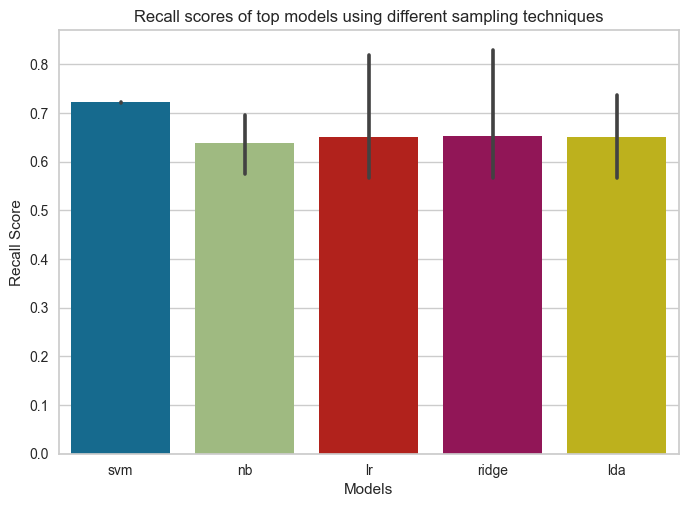

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(data=imbalance_type_dict)
df = df.T.drop(columns='dummy', axis=1)
print(df)

sns.barplot(data=df)
plt.xlabel('Models')
plt.ylabel('Recall Score')
plt.title('Recall scores of top models using different sampling techniques')
plt.show()

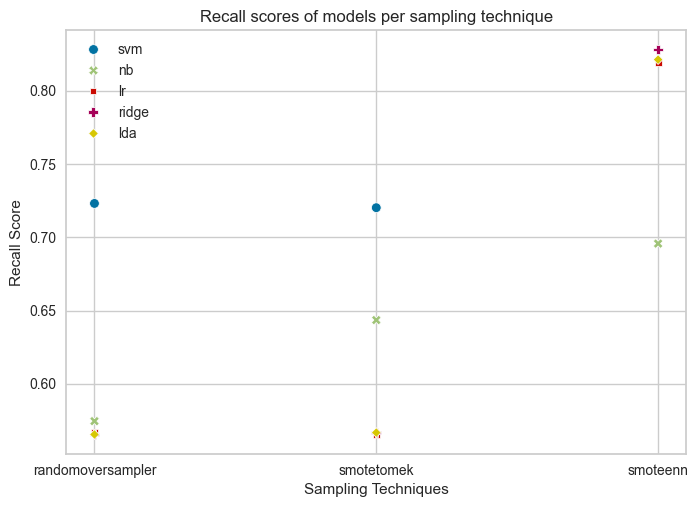

In [13]:
sns.scatterplot(df)
plt.xlabel('Sampling Techniques')
plt.ylabel('Recall Score')
plt.title('Recall scores of models per sampling technique')
plt.show()

Based on multiple tests to see what models and sampling techniques worked best, the results show a smoteenn technique working better for recall scores and the models that performed the best with smoteenn will be used along with svm.

### Model Experimentation
* This section will look at different models to explore as well as look at replicating some of the scores from above with the different sampling techniques

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.combine import SMOTETomek, SMOTEENN

ros = RandomOverSampler(random_state=seed)
smotenc = SMOTENC(categorical_features=categ_features, sampling_strategy='all', random_state=seed)
smoteenn = SMOTEENN(random_state=seed)

dummy_df = pd.get_dummies(new_X)

X_train, X_test, y_train, y_test = train_test_split(dummy_df,
                                                    new_y, 
                                                    train_size=.80, 
                                                    random_state=seed
                                                    )

X_train_resample, y_train_resample = smoteenn.fit_resample(X_train, y_train)

In [15]:
original_target_distribution = new_y.sum()/new_X.shape[0]
original_target_distribution

0.0724

In [16]:
y_train_resample.sum()/X_train_resample.shape[0]

0.6184314344326969

In [17]:
lr = LogisticRegression(random_state=seed)
lda = LinearDiscriminantAnalysis()
ridge = RidgeClassifier(random_state=seed)
gaussian_nb = GaussianNB()
sdg = SGDClassifier(random_state=seed)

models_dict = {
    'Logistic Regression': lr,
    'Linear Discrimination Analysis': lda,
    'Ridge Classifier': ridge,
    'Gaussian Naive-Bayes': gaussian_nb,
    'Stochastic Gradient Descent': sdg
    }


In [19]:
sampling_techniques = [ros, SMOTETomek(random_state=seed), smoteenn]

for tech in sampling_techniques:
    dummy_df = pd.get_dummies(new_X)

    X_train, X_test, y_train, y_test = train_test_split(dummy_df, new_y, train_size=.80, random_state=seed)

    X_train_resample, y_train_resample = tech.fit_resample(X_train, y_train)

    print(f"Sampling technique: {tech}")
    for name, model in models_dict.items():
        print(f"{'*'*40} Model: {name} {'*'*40}")
        model.fit(X_train_resample, y_train_resample)
        y_preds = model.predict(X_test)
        print(classification_report(y_test, y_preds))
        print(confusion_matrix(y_test, y_preds))

Sampling technique: RandomOverSampler(random_state=8867, sampling_strategy='auto', shrinkage=None)
**************************************** Model: Logistic Regression ****************************************
              precision    recall  f1-score   support

           0       0.95      0.59      0.73      7417
           1       0.10      0.58      0.17       583

    accuracy                           0.59      8000
   macro avg       0.52      0.59      0.45      8000
weighted avg       0.89      0.59      0.69      8000

[[4397 3020]
 [ 246  337]]
**************************************** Model: Linear Discrimination Analysis ****************************************
              precision    recall  f1-score   support

           0       0.95      0.60      0.73      7417
           1       0.10      0.56      0.17       583

    accuracy                           0.59      8000
   macro avg       0.52      0.58      0.45      8000
weighted avg       0.88      0.59      0.69   

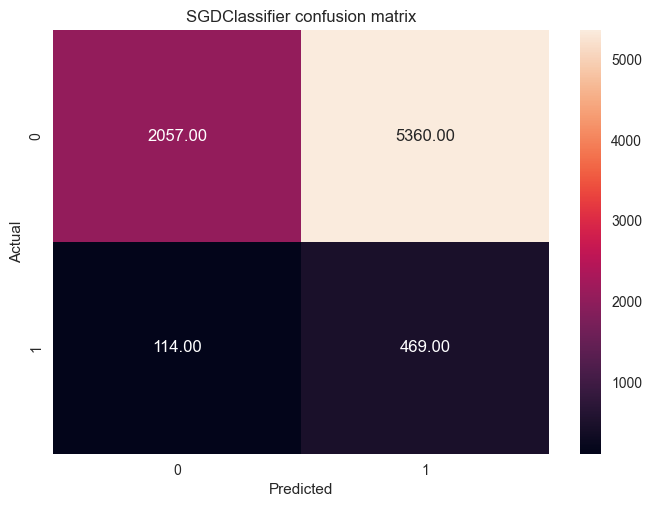

In [20]:
models_dict['Stochastic Gradient Descent'].fit(X_train_resample, y_train_resample)
pred = models_dict['Stochastic Gradient Descent'].predict(X_test)

sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt='.2f')
plt.title('SGDClassifier confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Hyperparameter Tuning
* SGDClassifier model will be tuned due to the fact that the amount of false negatives where considerably lower than the other models

In [21]:
import numpy as np
import optuna

n = X_train_resample.shape[0]
svm = models_dict['Stochastic Gradient Descent']

params = {
    'alpha': np.arange(.0000001, 1, 10),
    # 'max_iter': np.arange(1, 1000, 100)
    'max_iter': np.arange(200, 1000, 50)
}

random_grid_search = RandomizedSearchCV(estimator=svm, param_distributions=params, random_state=seed, cv=5, scoring='recall')

random_grid_search.fit(X_train_resample, y_train_resample)

preds = random_grid_search.predict(X_test)
print(f"Best params: {random_grid_search.best_params_}")

Best params: {'max_iter': 800, 'alpha': 1e-07}


In [22]:
tuned_sgd = SGDClassifier(alpha=1e-07, max_iter=900)
tuned_sgd.fit(X_train_resample, y_train_resample)

preds = tuned_sgd.predict(X_test)

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      7417
           1       0.05      0.09      0.07       583

    accuracy                           0.82      8000
   macro avg       0.49      0.48      0.48      8000
weighted avg       0.86      0.82      0.84      8000

[[6547  870]
 [ 533   50]]


In [23]:
def objective(trial):
    svm_alpha = trial.suggest_float('svm_alpha', 1e-07, 1, log=True)
    svm_max_iter = trial.suggest_int('svm_max_iter', 200, 1000)
    regressor_obj = SGDClassifier(alpha=svm_alpha, max_iter=svm_max_iter)
    
    dummy_df = pd.get_dummies(new_X)
    
    X_train, X_test, y_train, y_test = train_test_split(dummy_df, new_y, train_size=.80, random_state=seed)

    X_train_resample, y_train_resample = smoteenn.fit_resample(X_train, y_train)

    regressor_obj.fit(X_train_resample, y_train_resample)
    preds = regressor_obj.predict(X_test)
    print(classification_report(y_test, preds))

study = optuna.create_study()
study.optimize(objective, n_trials=10)

[I 2024-10-08 13:53:18,344] A new study created in memory with name: no-name-50d059dc-6f99-4a58-aa00-4b9c3456e449
[W 2024-10-08 13:54:24,318] Trial 0 failed with parameters: {'svm_alpha': 3.6292792435765286e-06, 'svm_max_iter': 592} because of the following error: The value None could not be cast to float..
[W 2024-10-08 13:54:24,323] Trial 0 failed with value None.


              precision    recall  f1-score   support

           0       0.95      0.22      0.35      7417
           1       0.08      0.85      0.14       583

    accuracy                           0.26      8000
   macro avg       0.51      0.53      0.25      8000
weighted avg       0.88      0.26      0.34      8000



[W 2024-10-08 13:55:34,357] Trial 1 failed with parameters: {'svm_alpha': 3.885034121044222e-05, 'svm_max_iter': 214} because of the following error: The value None could not be cast to float..
[W 2024-10-08 13:55:34,361] Trial 1 failed with value None.


              precision    recall  f1-score   support

           0       0.92      0.90      0.91      7417
           1       0.05      0.07      0.06       583

    accuracy                           0.84      8000
   macro avg       0.49      0.48      0.49      8000
weighted avg       0.86      0.84      0.85      8000



[W 2024-10-08 13:56:50,913] Trial 2 failed with parameters: {'svm_alpha': 1.1120589874106451e-05, 'svm_max_iter': 414} because of the following error: The value None could not be cast to float..
[W 2024-10-08 13:56:50,915] Trial 2 failed with value None.


              precision    recall  f1-score   support

           0       0.93      0.87      0.90      7417
           1       0.06      0.10      0.07       583

    accuracy                           0.82      8000
   macro avg       0.49      0.49      0.49      8000
weighted avg       0.86      0.82      0.84      8000



[W 2024-10-08 13:57:56,166] Trial 3 failed with parameters: {'svm_alpha': 5.09825124683097e-07, 'svm_max_iter': 803} because of the following error: The value None could not be cast to float..
[W 2024-10-08 13:57:56,177] Trial 3 failed with value None.


              precision    recall  f1-score   support

           0       0.95      0.23      0.37      7417
           1       0.08      0.84      0.14       583

    accuracy                           0.27      8000
   macro avg       0.51      0.54      0.26      8000
weighted avg       0.89      0.27      0.35      8000



[W 2024-10-08 13:59:01,381] Trial 4 failed with parameters: {'svm_alpha': 0.05369380192167171, 'svm_max_iter': 880} because of the following error: The value None could not be cast to float..
[W 2024-10-08 13:59:01,386] Trial 4 failed with value None.


              precision    recall  f1-score   support

           0       0.93      0.87      0.90      7417
           1       0.06      0.10      0.08       583

    accuracy                           0.82      8000
   macro avg       0.49      0.49      0.49      8000
weighted avg       0.86      0.82      0.84      8000



[W 2024-10-08 14:00:05,614] Trial 5 failed with parameters: {'svm_alpha': 0.13439853839289537, 'svm_max_iter': 971} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:00:05,620] Trial 5 failed with value None.


              precision    recall  f1-score   support

           0       0.95      0.20      0.33      7417
           1       0.08      0.86      0.14       583

    accuracy                           0.25      8000
   macro avg       0.51      0.53      0.24      8000
weighted avg       0.89      0.25      0.32      8000



[W 2024-10-08 14:01:12,890] Trial 6 failed with parameters: {'svm_alpha': 0.19811417039278711, 'svm_max_iter': 899} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:01:12,892] Trial 6 failed with value None.


              precision    recall  f1-score   support

           0       0.95      0.17      0.29      7417
           1       0.08      0.89      0.14       583

    accuracy                           0.22      8000
   macro avg       0.52      0.53      0.22      8000
weighted avg       0.89      0.22      0.28      8000



[W 2024-10-08 14:02:20,071] Trial 7 failed with parameters: {'svm_alpha': 5.7612120312796716e-05, 'svm_max_iter': 649} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:02:20,073] Trial 7 failed with value None.


              precision    recall  f1-score   support

           0       0.95      0.46      0.62      7417
           1       0.09      0.67      0.16       583

    accuracy                           0.48      8000
   macro avg       0.52      0.57      0.39      8000
weighted avg       0.88      0.48      0.59      8000



[W 2024-10-08 14:03:30,048] Trial 8 failed with parameters: {'svm_alpha': 5.0870409512061786e-05, 'svm_max_iter': 763} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:03:30,051] Trial 8 failed with value None.


              precision    recall  f1-score   support

           0       0.95      0.37      0.53      7417
           1       0.08      0.74      0.15       583

    accuracy                           0.39      8000
   macro avg       0.52      0.55      0.34      8000
weighted avg       0.88      0.39      0.50      8000



[W 2024-10-08 14:04:36,578] Trial 9 failed with parameters: {'svm_alpha': 2.8813064808560892e-05, 'svm_max_iter': 842} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:04:36,581] Trial 9 failed with value None.


              precision    recall  f1-score   support

           0       0.95      0.21      0.34      7417
           1       0.08      0.85      0.14       583

    accuracy                           0.25      8000
   macro avg       0.51      0.53      0.24      8000
weighted avg       0.88      0.25      0.32      8000



In [24]:
sdg = SGDClassifier(alpha=0.004591268532654977, max_iter=540, random_state=seed)

sdg.fit(X_train_resample, y_train_resample)
preds = sdg.predict(X_test)

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7417
           1       0.15      0.07      0.09       583

    accuracy                           0.90      8000
   macro avg       0.54      0.52      0.52      8000
weighted avg       0.87      0.90      0.89      8000

[[7196  221]
 [ 544   39]]


              precision    recall  f1-score   support

           0       0.99      0.47      0.63      7433
           1       0.12      0.93      0.21       567

    accuracy                           0.50      8000
   macro avg       0.55      0.70      0.42      8000
weighted avg       0.93      0.50      0.60      8000



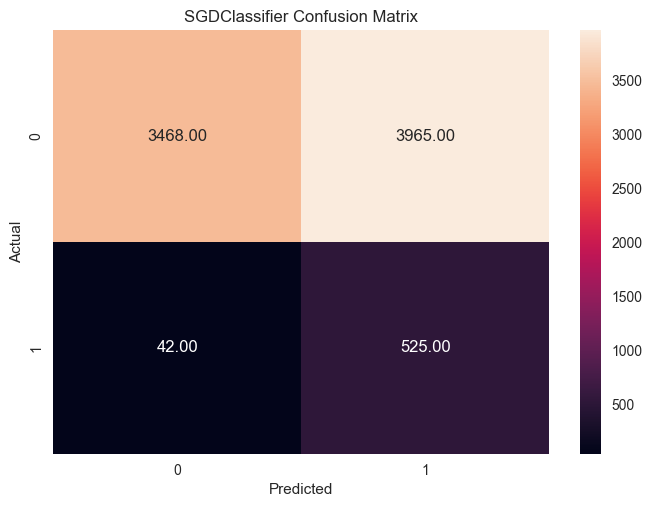

In [25]:
## using the trained, RandomizedSearch SGD model from above this now trains on the whole dataset to see how well it predicts customers who will subscribe

X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(X), target_variable, train_size=.80, random_state=seed)
X_train_resample, y_train_resample = smoteenn.fit_resample(X_train, y_train)

tuned_sgd.fit(X_train_resample, y_train_resample)
preds = tuned_sgd.predict(X_test)
print(classification_report(y_test, preds))
sns.heatmap(data=confusion_matrix(y_test, preds), fmt='.2f', annot=True)
plt.title('SGDClassifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Using the trained SGD model on the whole dataset using SMOTEenn for the sampling technique we can see that a recall score of ~91% is achieved. Meaning, this model is correctly classifying over 90% of the customers in the dataset as customers who ACTUALLY subscribed to the term deposit product thus saving roughly 173 hours of call time (number of true negatives * median call time of 3 minutes)/60.

## Post-Campaign Modeling
* The second section of this notebook looks to take the whole dataset and see how much additional call time can be reduced as well as looking at what makes a customer subscribe to the product using unsupervised learning techniques.
* Using Pycaret, we will see which models perform well with the entire dataset looking at different metrics such as precision, recall, and f1_macro.
* For reproducability purposes, use seed=3121

In [26]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,duration_in_minutes
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,4.350000
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,2.516667
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,1.266667
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,1,1.533333
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,1,3.300000


In [27]:
full_dataset_categorical_features = [col for col in X.columns if X[col].dtype == 'category']
full_dataset_categorical_features

['job', 'marital', 'education', 'contact', 'month']

In [28]:
seed = 3121

In [29]:
# seed = random.randint(1000, 9999)

imbalance_type_dict_layer_2 = {}

for type in imbalance_methods:
  print(f'Type of imbalance technique: {type}')
  s = setup(data=X,
        target=target_variable, 
        session_id=seed, 
        train_size=.80, 
        fix_imbalance=True, 
        fix_imbalance_method=type,
        categorical_features=full_dataset_categorical_features
      )
  # print(s.X_train)
  print()
  best_models = compare_models(sort='Precision', n_select=n_select)
  results = pull()
  # print(best_models)

  model_precision_score_dict = {}

  for i in range(n_select):
      model_precision_score_dict[results.index[i]] = results.iloc[i]['Prec.']

  imbalance_type_dict_layer_2[type] = model_precision_score_dict

  print(imbalance_type_dict_layer_2)

  # evaluation = [evaluate_model(estimator=model) for model in best_models]
  print('-'*50)

Type of imbalance technique: randomoversampler


,Description,Value
0,Session id,3121
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 14)"
4,Transformed data shape,"(67366, 42)"
5,Transformed train set shape,"(59366, 42)"
6,Transformed test set shape,"(8000, 42)"
7,Numeric features,8
8,Categorical features,5
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9317,0.9220,0.2214,0.5765,0.3188,0.2903,0.3281,1.7620
rf,Random Forest Classifier,0.9343,0.9432,0.4199,0.5619,0.4802,0.4460,0.4516,1.6460
dt,Decision Tree Classifier,0.9190,0.6919,0.4264,0.4397,0.4325,0.3889,0.3892,0.2420
xgboost,Extreme Gradient Boosting,0.9085,0.9419,0.7708,0.4274,0.5496,0.5033,0.5307,0.4410
lightgbm,Light Gradient Boosting Machine,0.8903,0.9499,0.8874,0.3880,0.5398,0.4882,0.5424,0.6480
ridge,Ridge Classifier,0.8777,0.9262,0.8278,0.3534,0.4952,0.4382,0.4899,0.1410
lda,Linear Discriminant Analysis,0.8777,0.9262,0.8274,0.3533,0.4950,0.4380,0.4897,0.1940
gbc,Gradient Boosting Classifier,0.8724,0.9438,0.8917,0.3509,0.5034,0.4458,0.5101,2.8430
ada,Ada Boost Classifier,0.8685,0.9295,0.8507,0.3385,0.4841,0.4245,0.4841,0.7860
lr,Logistic Regression,0.8657,0.9297,0.8623,0.3347,0.4821,0.4217,0.4845,2.9820


{'randomoversampler': {'et': 0.5765, 'rf': 0.5619, 'dt': 0.4397, 'xgboost': 0.4274, 'lightgbm': 0.388}}
--------------------------------------------------
Type of imbalance technique: smotetomek


,Description,Value
0,Session id,3121
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 14)"
4,Transformed data shape,"(66800, 42)"
5,Transformed train set shape,"(58800, 42)"
6,Transformed test set shape,"(8000, 42)"
7,Numeric features,8
8,Categorical features,5
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9388,0.9513,0.4774,0.5977,0.5303,0.4980,0.5019,7.0930
xgboost,Extreme Gradient Boosting,0.9367,0.9471,0.4670,0.5788,0.5164,0.4830,0.4865,7.2470
rf,Random Forest Classifier,0.9330,0.9409,0.3250,0.5656,0.4123,0.3796,0.3963,8.1990
et,Extra Trees Classifier,0.9318,0.9301,0.3129,0.5529,0.3989,0.3658,0.3829,8.4160
gbc,Gradient Boosting Classifier,0.9323,0.9415,0.5106,0.5351,0.5219,0.4855,0.4860,12.5650
ada,Ada Boost Classifier,0.9215,0.9207,0.4441,0.4580,0.4500,0.4078,0.4084,7.5610
dt,Decision Tree Classifier,0.9159,0.7098,0.4687,0.4265,0.4463,0.4010,0.4017,6.5450
ridge,Ridge Classifier,0.8806,0.9287,0.8269,0.3594,0.5009,0.4449,0.4950,6.4880
lda,Linear Discriminant Analysis,0.8805,0.9287,0.8269,0.3593,0.5008,0.4447,0.4949,7.5490
lr,Logistic Regression,0.8715,0.9297,0.8468,0.3436,0.4887,0.4300,0.4876,8.1810


{'randomoversampler': {'et': 0.5765, 'rf': 0.5619, 'dt': 0.4397, 'xgboost': 0.4274, 'lightgbm': 0.388}, 'smotetomek': {'lightgbm': 0.5977, 'xgboost': 0.5788, 'rf': 0.5656, 'et': 0.5529, 'gbc': 0.5351}}
--------------------------------------------------
Type of imbalance technique: smoteenn


,Description,Value
0,Session id,3121
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 14)"
4,Transformed data shape,"(58311, 42)"
5,Transformed train set shape,"(50311, 42)"
6,Transformed test set shape,"(8000, 42)"
7,Numeric features,8
8,Categorical features,5
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9270,0.9366,0.5663,0.4963,0.5288,0.4894,0.4908,10.8690
lightgbm,Light Gradient Boosting Machine,0.9252,0.9484,0.7156,0.4887,0.5805,0.5410,0.5530,9.6820
xgboost,Extreme Gradient Boosting,0.9233,0.9443,0.6932,0.4796,0.5666,0.5261,0.5370,10.8800
rf,Random Forest Classifier,0.9224,0.9412,0.6461,0.4742,0.5467,0.5054,0.5128,8.4100
gbc,Gradient Boosting Classifier,0.9122,0.9400,0.7216,0.4366,0.5438,0.4985,0.5180,11.3180
ada,Ada Boost Classifier,0.9093,0.9230,0.6595,0.4198,0.5128,0.4655,0.4801,8.5610
dt,Decision Tree Classifier,0.9057,0.7920,0.6591,0.4071,0.5029,0.4540,0.4704,6.3230
lda,Linear Discriminant Analysis,0.8576,0.9289,0.8744,0.3224,0.4710,0.4084,0.4767,6.1290
ridge,Ridge Classifier,0.8575,0.9289,0.8744,0.3222,0.4707,0.4081,0.4765,6.5510
lr,Logistic Regression,0.8453,0.9295,0.8839,0.3051,0.4534,0.3874,0.4623,8.4470


{'randomoversampler': {'et': 0.5765, 'rf': 0.5619, 'dt': 0.4397, 'xgboost': 0.4274, 'lightgbm': 0.388}, 'smotetomek': {'lightgbm': 0.5977, 'xgboost': 0.5788, 'rf': 0.5656, 'et': 0.5529, 'gbc': 0.5351}, 'smoteenn': {'et': 0.4963, 'lightgbm': 0.4887, 'xgboost': 0.4796, 'rf': 0.4742, 'gbc': 0.4366}}
--------------------------------------------------


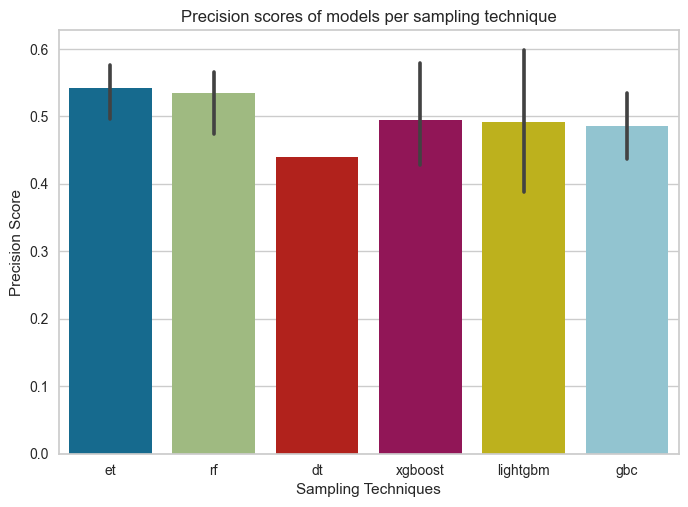

In [30]:
df = pd.DataFrame(imbalance_type_dict_layer_2)
df = df.T

sns.barplot(df)
plt.xlabel('Sampling Techniques')
plt.ylabel('Precision Score')
plt.title('Precision scores of models per sampling technique')
plt.show()

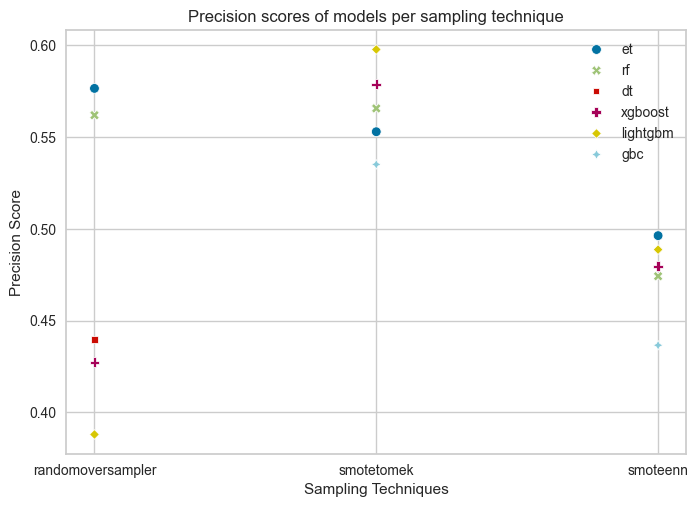

In [31]:
sns.scatterplot(df)
plt.xlabel('Sampling Techniques')
plt.ylabel('Precision Score')
plt.title('Precision scores of models per sampling technique')
plt.show()

Using Pycaret to see what models work with different sampling techniques the results look to be that multiple tree based models work the best with SmoteTomek as the sampling technique. Below, the ExtraTreeClassifier will be used with a randomoversampling technique and a LightGBM model will be used with SmoteTomek.

In [217]:
from imblearn.over_sampling import RandomOverSampler

dummy_new_X = pd.get_dummies(data=s.X)

X_train, X_test, y_train, y_test = train_test_split(dummy_new_X, s.y, train_size=.80, random_state=seed)
X_train_resampled_tomek, y_train_resampled_tomek = SMOTETomek(random_state=seed).fit_resample(X_train, y_train)
X_train_resampled_random, y_train_resampled_random = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)


In [33]:
from sklearn.tree import ExtraTreeClassifier
from lightgbm import LGBMClassifier

second_layer_models = {
    'extra_tree': ExtraTreeClassifier(random_state=seed),
    'lightgbm': LGBMClassifier(random_state=seed)
}

for name, model in second_layer_models.items():
    print(f"{'*'*40} Model: {name} {'*'*40}")
    if name == 'extra_tree':
        extra_tree = model
        extra_tree.fit(X_train_resampled_random, y_train_resampled_random)
        preds = extra_tree.predict(X_test)
        print(classification_report(y_test, preds))
        print(confusion_matrix(y_test, preds))
    else:
        lgbm = model
        lgbm.fit(X_train_resampled_tomek, y_train_resampled_tomek)
        preds = lgbm.predict(X_test)
        print(classification_report(y_test, preds))
        print(confusion_matrix(y_test, preds))

**************************************** Model: extra_tree ****************************************
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7413
           1       0.36      0.36      0.36       587

    accuracy                           0.91      8000
   macro avg       0.66      0.65      0.65      8000
weighted avg       0.91      0.91      0.91      8000

[[7043  370]
 [ 378  209]]
**************************************** Model: lightgbm ****************************************
[LightGBM] [Info] Number of positive: 29395, number of negative: 29395
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 58790, number of used features: 40
[LightGBM] [Info] [binary

In [34]:
from sklearn.metrics import f1_score

class_weights = np.linspace(0.0, .99, 30)

results_list = []
false_pos_list = []
false_neg_list = []
f1_list = []

for i in class_weights:
    model = LGBMClassifier(class_weight={0:i, 1:1.0-i})
    model.fit(X_train_resampled_tomek, y_train_resampled_tomek)
    preds=model.predict(X_test)
    conf_matrix=confusion_matrix(y_test, preds)
    fp=conf_matrix[0][1]
    fn=conf_matrix[1][0]

    results_list.append(results)
    false_pos_list.append(fp)
    false_neg_list.append(fn)
    print(f"Class 0 weight: {i} - Class 1 weight: {1.0-i}")
    print(classification_report(y_test, preds))
    print(conf_matrix)


# print(class_weights)
# print(false_pos_list)
# print(false_neg_list)

[LightGBM] [Info] Number of positive: 29395, number of negative: 29395
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 58790, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

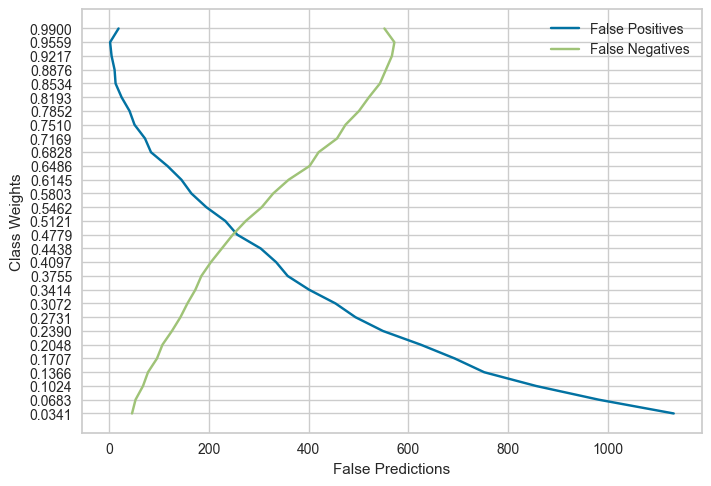

In [35]:
plt.plot(false_pos_list[1:], class_weights[1:])
plt.plot(false_neg_list[1:], class_weights[1:])
# plt.plot(f1_list, class_weights)
plt.yticks([i for i in class_weights[1:]])
plt.xlabel('False Predictions')
plt.ylabel('Class Weights')
plt.legend(('False Positives', 'False Negatives'))
plt.show()

In [36]:
params = {
    'max_depth': np.arange(1,8),
    'num_leaves': np.arange(2,100,10),
    'min_data_in_leaf': np.arange(100,10000,10),
    'num_iterations': np.arange(2,10),
    'class_weight': [{0:class_weights[14], 1:1-class_weights[14]}],
    'force_row_wise': [True],
    'verbose': [-1]
}

grid = RandomizedSearchCV(estimator=second_layer_models['lightgbm'], param_distributions=params, n_jobs=-1, random_state=seed, cv=5, scoring='precision')

grid.fit(X_train_resampled_tomek, y_train_resampled_tomek)
preds = grid.predict(X_test)
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))
print(f"Best params: {grid.best_params_}")

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.32      0.80      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.83      0.69      8000
weighted avg       0.93      0.86      0.88      8000

[[6404 1009]
 [ 120  467]]
Best params: {'verbose': -1, 'num_leaves': 42, 'num_iterations': 9, 'min_data_in_leaf': 1340, 'max_depth': 7, 'force_row_wise': True, 'class_weight': {0: 0.47793103448275864, 1: 0.5220689655172414}}


In [37]:
def objective(trial):
    lgb_max_depth = trial.suggest_int('lgb_max_depth', 1, 8)
    lgb_num_leaves = trial.suggest_int('lgb_num_leaves', 2,100)
    lgb_min_data_in_leaf = trial.suggest_int('lgb_min_data_in_leaf',100,10000,log=True)
    lgb_num_iter = trial.suggest_int('lgb_num_iter', 2,10)

    regressor_obj = LGBMClassifier(max_depth=lgb_max_depth, num_leaves=lgb_num_leaves, min_data_in_leaf=lgb_min_data_in_leaf, num_iterations=lgb_num_iter, class_weight={0:class_weights[14], 1:1-class_weights[14]}, random_state=seed, force_row_wise=True, verbose=-1)
    
    dummy_df = pd.get_dummies(s.X)
    
    X_train, X_test, y_train, y_test = train_test_split(dummy_df, s.y, train_size=.80, random_state=seed)
    X_train_resample, y_train_resample = SMOTETomek(random_state=seed).fit_resample(X_train, y_train)

    regressor_obj.fit(X_train_resample, y_train_resample)
    preds = regressor_obj.predict(X_test)
    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

[I 2024-10-08 14:50:28,656] A new study created in memory with name: no-name-7efca341-72b6-412d-816b-458c11ce136a


[W 2024-10-08 14:50:44,433] Trial 0 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 43, 'lgb_min_data_in_leaf': 115, 'lgb_num_iter': 3} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:50:44,434] Trial 0 failed with value None.


              precision    recall  f1-score   support

           0       0.99      0.87      0.93      7413
           1       0.34      0.85      0.49       587

    accuracy                           0.87      8000
   macro avg       0.66      0.86      0.71      8000
weighted avg       0.94      0.87      0.89      8000

[[6459  954]
 [  89  498]]


[W 2024-10-08 14:50:57,610] Trial 1 failed with parameters: {'lgb_max_depth': 6, 'lgb_num_leaves': 53, 'lgb_min_data_in_leaf': 1695, 'lgb_num_iter': 7} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:50:57,613] Trial 1 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7413
           1       0.27      0.79      0.40       587

    accuracy                           0.83      8000
   macro avg       0.62      0.81      0.65      8000
weighted avg       0.93      0.83      0.86      8000

[[6158 1255]
 [ 124  463]]


[W 2024-10-08 14:51:09,920] Trial 2 failed with parameters: {'lgb_max_depth': 4, 'lgb_num_leaves': 62, 'lgb_min_data_in_leaf': 2806, 'lgb_num_iter': 8} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:51:09,921] Trial 2 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.28      0.81      0.42       587

    accuracy                           0.83      8000
   macro avg       0.63      0.82      0.66      8000
weighted avg       0.93      0.83      0.87      8000

[[6194 1219]
 [ 113  474]]


[W 2024-10-08 14:51:24,157] Trial 3 failed with parameters: {'lgb_max_depth': 4, 'lgb_num_leaves': 93, 'lgb_min_data_in_leaf': 197, 'lgb_num_iter': 3} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:51:24,159] Trial 3 failed with value None.


              precision    recall  f1-score   support

           0       0.99      0.81      0.89      7413
           1       0.27      0.86      0.41       587

    accuracy                           0.82      8000
   macro avg       0.63      0.84      0.65      8000
weighted avg       0.93      0.82      0.86      8000

[[6019 1394]
 [  82  505]]


[W 2024-10-08 14:51:35,985] Trial 4 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 27, 'lgb_min_data_in_leaf': 427, 'lgb_num_iter': 3} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:51:35,986] Trial 4 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.31      0.78      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.82      0.68      8000
weighted avg       0.93      0.86      0.88      8000

[[6408 1005]
 [ 128  459]]


[W 2024-10-08 14:51:48,764] Trial 5 failed with parameters: {'lgb_max_depth': 6, 'lgb_num_leaves': 32, 'lgb_min_data_in_leaf': 3829, 'lgb_num_iter': 6} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:51:48,765] Trial 5 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.80      0.88      7413
           1       0.25      0.82      0.38       587

    accuracy                           0.80      8000
   macro avg       0.62      0.81      0.63      8000
weighted avg       0.93      0.80      0.85      8000

[[5956 1457]
 [ 107  480]]


[W 2024-10-08 14:52:02,437] Trial 6 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 23, 'lgb_min_data_in_leaf': 357, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:52:02,439] Trial 6 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.26      0.74      0.39       587

    accuracy                           0.83      8000
   macro avg       0.62      0.79      0.65      8000
weighted avg       0.92      0.83      0.86      8000

[[6203 1210]
 [ 153  434]]


[W 2024-10-08 14:52:11,264] Trial 7 failed with parameters: {'lgb_max_depth': 8, 'lgb_num_leaves': 33, 'lgb_min_data_in_leaf': 4106, 'lgb_num_iter': 10} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:52:11,265] Trial 7 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7413
           1       0.27      0.80      0.41       587

    accuracy                           0.83      8000
   macro avg       0.63      0.82      0.65      8000
weighted avg       0.93      0.83      0.86      8000

[[6164 1249]
 [ 117  470]]


[W 2024-10-08 14:52:19,334] Trial 8 failed with parameters: {'lgb_max_depth': 4, 'lgb_num_leaves': 85, 'lgb_min_data_in_leaf': 224, 'lgb_num_iter': 7} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:52:19,335] Trial 8 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.32      0.80      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.83      0.69      8000
weighted avg       0.93      0.86      0.88      8000

[[6405 1008]
 [ 119  468]]


[W 2024-10-08 14:52:26,818] Trial 9 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 36, 'lgb_min_data_in_leaf': 286, 'lgb_num_iter': 2} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:52:26,820] Trial 9 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.81      0.88      7413
           1       0.24      0.75      0.36       587

    accuracy                           0.80      8000
   macro avg       0.61      0.78      0.62      8000
weighted avg       0.92      0.80      0.85      8000

[[5994 1419]
 [ 145  442]]


[W 2024-10-08 14:52:35,053] Trial 10 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 35, 'lgb_min_data_in_leaf': 1481, 'lgb_num_iter': 4} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:52:35,054] Trial 10 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.81      0.88      7413
           1       0.24      0.75      0.36       587

    accuracy                           0.80      8000
   macro avg       0.61      0.78      0.62      8000
weighted avg       0.92      0.80      0.85      8000

[[5994 1419]
 [ 145  442]]


[W 2024-10-08 14:52:42,637] Trial 11 failed with parameters: {'lgb_max_depth': 7, 'lgb_num_leaves': 83, 'lgb_min_data_in_leaf': 155, 'lgb_num_iter': 6} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:52:42,637] Trial 11 failed with value None.


              precision    recall  f1-score   support

           0       0.99      0.88      0.93      7413
           1       0.36      0.83      0.50       587

    accuracy                           0.88      8000
   macro avg       0.67      0.86      0.72      8000
weighted avg       0.94      0.88      0.90      8000

[[6545  868]
 [  97  490]]


[W 2024-10-08 14:52:50,403] Trial 12 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 64, 'lgb_min_data_in_leaf': 499, 'lgb_num_iter': 7} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:52:50,405] Trial 12 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7413
           1       0.34      0.80      0.48       587

    accuracy                           0.87      8000
   macro avg       0.66      0.84      0.70      8000
weighted avg       0.94      0.87      0.89      8000

[[6493  920]
 [ 117  470]]


[W 2024-10-08 14:52:57,888] Trial 13 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 99, 'lgb_min_data_in_leaf': 345, 'lgb_num_iter': 3} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:52:57,891] Trial 13 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.31      0.78      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.82      0.68      8000
weighted avg       0.93      0.86      0.88      8000

[[6408 1005]
 [ 128  459]]


[W 2024-10-08 14:53:05,985] Trial 14 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 25, 'lgb_min_data_in_leaf': 174, 'lgb_num_iter': 2} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:53:05,986] Trial 14 failed with value None.


              precision    recall  f1-score   support

           0       0.99      0.88      0.93      7413
           1       0.35      0.84      0.50       587

    accuracy                           0.87      8000
   macro avg       0.67      0.86      0.71      8000
weighted avg       0.94      0.87      0.90      8000

[[6503  910]
 [  91  496]]


[W 2024-10-08 14:53:13,810] Trial 15 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 21, 'lgb_min_data_in_leaf': 2885, 'lgb_num_iter': 4} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:53:13,811] Trial 15 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.81      0.88      7413
           1       0.24      0.75      0.36       587

    accuracy                           0.80      8000
   macro avg       0.61      0.78      0.62      8000
weighted avg       0.92      0.80      0.85      8000

[[5994 1419]
 [ 145  442]]


[W 2024-10-08 14:53:23,307] Trial 16 failed with parameters: {'lgb_max_depth': 2, 'lgb_num_leaves': 19, 'lgb_min_data_in_leaf': 4047, 'lgb_num_iter': 4} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:53:23,309] Trial 16 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7413
           1       0.27      0.80      0.40       587

    accuracy                           0.82      8000
   macro avg       0.62      0.81      0.65      8000
weighted avg       0.93      0.82      0.86      8000

[[6120 1293]
 [ 116  471]]


[W 2024-10-08 14:53:33,135] Trial 17 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 44, 'lgb_min_data_in_leaf': 2490, 'lgb_num_iter': 3} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:53:33,136] Trial 17 failed with value None.


              precision    recall  f1-score   support

           0       0.99      0.74      0.85      7413
           1       0.21      0.87      0.34       587

    accuracy                           0.75      8000
   macro avg       0.60      0.81      0.59      8000
weighted avg       0.93      0.75      0.81      8000

[[5509 1904]
 [  77  510]]


[W 2024-10-08 14:53:45,147] Trial 18 failed with parameters: {'lgb_max_depth': 4, 'lgb_num_leaves': 38, 'lgb_min_data_in_leaf': 358, 'lgb_num_iter': 6} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:53:45,148] Trial 18 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.31      0.79      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.82      0.68      8000
weighted avg       0.93      0.86      0.88      8000

[[6397 1016]
 [ 126  461]]


[W 2024-10-08 14:53:55,377] Trial 19 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 72, 'lgb_min_data_in_leaf': 1164, 'lgb_num_iter': 8} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:53:55,378] Trial 19 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7413
           1       0.30      0.80      0.44       587

    accuracy                           0.85      8000
   macro avg       0.64      0.83      0.68      8000
weighted avg       0.93      0.85      0.88      8000

[[6337 1076]
 [ 119  468]]


[W 2024-10-08 14:54:05,644] Trial 20 failed with parameters: {'lgb_max_depth': 8, 'lgb_num_leaves': 94, 'lgb_min_data_in_leaf': 406, 'lgb_num_iter': 7} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:54:05,644] Trial 20 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7413
           1       0.34      0.80      0.48       587

    accuracy                           0.87      8000
   macro avg       0.66      0.84      0.70      8000
weighted avg       0.94      0.87      0.89      8000

[[6489  924]
 [ 115  472]]


[W 2024-10-08 14:54:16,265] Trial 21 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 35, 'lgb_min_data_in_leaf': 2877, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:54:16,267] Trial 21 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.79      0.88      7413
           1       0.24      0.83      0.37       587

    accuracy                           0.79      8000
   macro avg       0.61      0.81      0.62      8000
weighted avg       0.93      0.79      0.84      8000

[[5862 1551]
 [ 101  486]]


[W 2024-10-08 14:54:26,532] Trial 22 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 50, 'lgb_min_data_in_leaf': 550, 'lgb_num_iter': 7} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:54:26,532] Trial 22 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7413
           1       0.33      0.80      0.47       587

    accuracy                           0.87      8000
   macro avg       0.66      0.84      0.70      8000
weighted avg       0.93      0.87      0.89      8000

[[6459  954]
 [ 115  472]]


[W 2024-10-08 14:54:37,684] Trial 23 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 33, 'lgb_min_data_in_leaf': 201, 'lgb_num_iter': 3} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:54:37,685] Trial 23 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.26      0.74      0.39       587

    accuracy                           0.83      8000
   macro avg       0.62      0.79      0.65      8000
weighted avg       0.92      0.83      0.86      8000

[[6203 1210]
 [ 153  434]]


[W 2024-10-08 14:54:48,768] Trial 24 failed with parameters: {'lgb_max_depth': 8, 'lgb_num_leaves': 52, 'lgb_min_data_in_leaf': 888, 'lgb_num_iter': 7} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:54:48,769] Trial 24 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7413
           1       0.33      0.82      0.47       587

    accuracy                           0.86      8000
   macro avg       0.65      0.84      0.69      8000
weighted avg       0.94      0.86      0.89      8000

[[6419  994]
 [ 108  479]]


[W 2024-10-08 14:54:59,355] Trial 25 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 4, 'lgb_min_data_in_leaf': 1396, 'lgb_num_iter': 3} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:54:59,357] Trial 25 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.79      0.87      7413
           1       0.23      0.82      0.36       587

    accuracy                           0.79      8000
   macro avg       0.61      0.80      0.62      8000
weighted avg       0.93      0.79      0.84      8000

[[5842 1571]
 [ 106  481]]


[W 2024-10-08 14:55:09,694] Trial 26 failed with parameters: {'lgb_max_depth': 2, 'lgb_num_leaves': 50, 'lgb_min_data_in_leaf': 1425, 'lgb_num_iter': 2} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:55:09,695] Trial 26 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.78      0.87      7413
           1       0.23      0.83      0.35       587

    accuracy                           0.78      8000
   macro avg       0.60      0.80      0.61      8000
weighted avg       0.93      0.78      0.83      8000

[[5747 1666]
 [ 102  485]]


[W 2024-10-08 14:55:20,141] Trial 27 failed with parameters: {'lgb_max_depth': 2, 'lgb_num_leaves': 93, 'lgb_min_data_in_leaf': 281, 'lgb_num_iter': 10} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:55:20,143] Trial 27 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.28      0.77      0.41       587

    accuracy                           0.83      8000
   macro avg       0.63      0.81      0.66      8000
weighted avg       0.93      0.83      0.87      8000

[[6224 1189]
 [ 134  453]]


[W 2024-10-08 14:55:36,649] Trial 28 failed with parameters: {'lgb_max_depth': 8, 'lgb_num_leaves': 7, 'lgb_min_data_in_leaf': 1099, 'lgb_num_iter': 8} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:55:36,651] Trial 28 failed with value None.


              precision    recall  f1-score   support

           0       0.99      0.85      0.91      7413
           1       0.31      0.84      0.45       587

    accuracy                           0.85      8000
   macro avg       0.65      0.85      0.68      8000
weighted avg       0.94      0.85      0.88      8000

[[6303 1110]
 [  94  493]]


[W 2024-10-08 14:55:53,662] Trial 29 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 88, 'lgb_min_data_in_leaf': 190, 'lgb_num_iter': 6} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:55:53,665] Trial 29 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.31      0.78      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.82      0.68      8000
weighted avg       0.93      0.86      0.88      8000

[[6400 1013]
 [ 127  460]]


[W 2024-10-08 14:56:09,410] Trial 30 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 64, 'lgb_min_data_in_leaf': 799, 'lgb_num_iter': 10} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:56:09,412] Trial 30 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.81      0.88      7413
           1       0.24      0.75      0.36       587

    accuracy                           0.80      8000
   macro avg       0.61      0.78      0.62      8000
weighted avg       0.92      0.80      0.85      8000

[[5994 1419]
 [ 145  442]]


[W 2024-10-08 14:56:21,883] Trial 31 failed with parameters: {'lgb_max_depth': 7, 'lgb_num_leaves': 63, 'lgb_min_data_in_leaf': 4781, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:56:21,885] Trial 31 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.79      0.88      7413
           1       0.24      0.82      0.37       587

    accuracy                           0.79      8000
   macro avg       0.61      0.80      0.62      8000
weighted avg       0.93      0.79      0.84      8000

[[5851 1562]
 [ 107  480]]


[W 2024-10-08 14:56:30,490] Trial 32 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 98, 'lgb_min_data_in_leaf': 1506, 'lgb_num_iter': 2} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:56:30,492] Trial 32 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.81      0.88      7413
           1       0.24      0.75      0.36       587

    accuracy                           0.80      8000
   macro avg       0.61      0.78      0.62      8000
weighted avg       0.92      0.80      0.85      8000

[[5994 1419]
 [ 145  442]]


[W 2024-10-08 14:56:37,813] Trial 33 failed with parameters: {'lgb_max_depth': 6, 'lgb_num_leaves': 44, 'lgb_min_data_in_leaf': 112, 'lgb_num_iter': 6} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:56:37,813] Trial 33 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7413
           1       0.36      0.83      0.50       587

    accuracy                           0.88      8000
   macro avg       0.67      0.86      0.72      8000
weighted avg       0.94      0.88      0.90      8000

[[6556  857]
 [ 100  487]]


[W 2024-10-08 14:56:44,965] Trial 34 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 40, 'lgb_min_data_in_leaf': 4633, 'lgb_num_iter': 4} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:56:44,965] Trial 34 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.80      0.88      7413
           1       0.24      0.81      0.37       587

    accuracy                           0.80      8000
   macro avg       0.61      0.80      0.62      8000
weighted avg       0.93      0.80      0.84      8000

[[5901 1512]
 [ 110  477]]


[W 2024-10-08 14:56:52,892] Trial 35 failed with parameters: {'lgb_max_depth': 2, 'lgb_num_leaves': 44, 'lgb_min_data_in_leaf': 1397, 'lgb_num_iter': 6} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:56:52,893] Trial 35 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.27      0.76      0.40       587

    accuracy                           0.83      8000
   macro avg       0.62      0.80      0.65      8000
weighted avg       0.93      0.83      0.86      8000

[[6190 1223]
 [ 141  446]]


[W 2024-10-08 14:57:00,157] Trial 36 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 92, 'lgb_min_data_in_leaf': 955, 'lgb_num_iter': 10} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:57:00,157] Trial 36 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.81      0.88      7413
           1       0.24      0.75      0.36       587

    accuracy                           0.80      8000
   macro avg       0.61      0.78      0.62      8000
weighted avg       0.92      0.80      0.85      8000

[[5994 1419]
 [ 145  442]]


[W 2024-10-08 14:57:07,371] Trial 37 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 90, 'lgb_min_data_in_leaf': 199, 'lgb_num_iter': 7} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:57:07,371] Trial 37 failed with value None.


              precision    recall  f1-score   support

           0       0.99      0.87      0.92      7413
           1       0.33      0.84      0.48       587

    accuracy                           0.86      8000
   macro avg       0.66      0.85      0.70      8000
weighted avg       0.94      0.86      0.89      8000

[[6421  992]
 [  94  493]]


[W 2024-10-08 14:57:14,498] Trial 38 failed with parameters: {'lgb_max_depth': 4, 'lgb_num_leaves': 98, 'lgb_min_data_in_leaf': 1785, 'lgb_num_iter': 3} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:57:14,499] Trial 38 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.79      0.87      7413
           1       0.23      0.82      0.36       587

    accuracy                           0.79      8000
   macro avg       0.61      0.80      0.62      8000
weighted avg       0.93      0.79      0.84      8000

[[5836 1577]
 [ 106  481]]


[W 2024-10-08 14:57:21,525] Trial 39 failed with parameters: {'lgb_max_depth': 2, 'lgb_num_leaves': 72, 'lgb_min_data_in_leaf': 420, 'lgb_num_iter': 3} because of the following error: The value None could not be cast to float..
[W 2024-10-08 14:57:21,526] Trial 39 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.80      0.88      7413
           1       0.24      0.81      0.37       587

    accuracy                           0.80      8000
   macro avg       0.61      0.81      0.63      8000
weighted avg       0.93      0.80      0.84      8000

[[5935 1478]
 [ 111  476]]


              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7413
           1       0.38      0.82      0.52       587

    accuracy                           0.89      8000
   macro avg       0.68      0.86      0.73      8000
weighted avg       0.94      0.89      0.91      8000



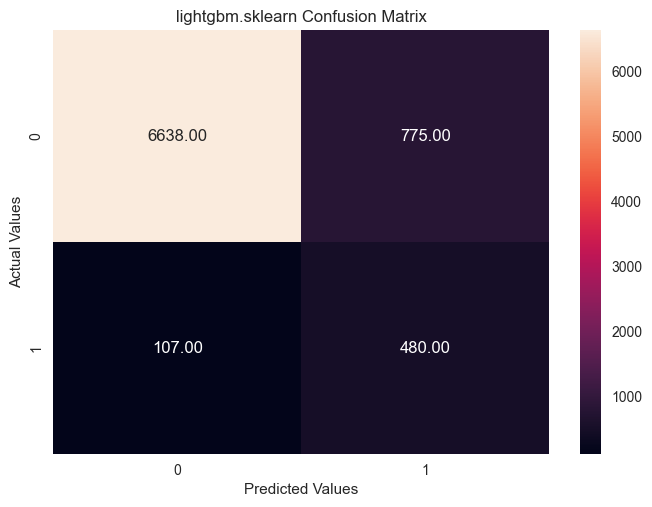

In [38]:

lgb_tuned = LGBMClassifier(max_depth=8,
                           num_leaves=59,
                           min_data_in_leaf=194,
                           num_iterations=10,
                           class_weight={0:class_weights[14], 1:1-class_weights[14]},
                           random_state=seed,
                           force_row_wise=True,
                           verbose=-1
                           )

lgb_tuned.fit(X_train_resampled_tomek, y_train_resampled_tomek)
preds = lgb_tuned.predict(X_test)
print(classification_report(y_test, preds))
sns.heatmap(data=confusion_matrix(y_test, preds), annot=True, fmt='.2f')
plt.title(f'{lgb_tuned.__module__} Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In the end, not JUT looking at precision score was optimal for this model. Looking for a model that ultimately classified as many true negatives as possible, had a fairly decent precision score and had a good recall score along with a good f1 macro score was the model to look for.
In our case the tuned LGBMClassifier reduced call time by roughly 330 hours by identifying over 6600 customers that are NOT going to subscribe to the term deposit product while only losing 107 customers.

In [39]:
duration_of_calls_in_hours = round(X['duration_in_minutes'].sum()/60, 2)
print(f"The total amount of call time during the entirety of the campaign was {duration_of_calls_in_hours} hours.")

The total amount of call time during the entirety of the campaign was 2831.38 hours.


### Feature Selection
* Using heirarchical clustering and KMeans clustering this section looks to find features that will be helpful to look at when assessing whether a customer will subscribe to the product or not.
* Since the dataset has multiple features that are not easily represented in a 2-dimensional space t-SNE will be implemented to help with dimensionality reduction.

In [625]:
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

######## set X and y to the X and y variables used by pycaret 
X = s.X
y = s.y
X['y'] = y
X = X[X['y']==1]
X.drop('y', axis=1, inplace=True)

dummied_X = pd.get_dummies(X)
numeric_cols = [col for col in dummied_X.columns if dummied_X[col].dtype!='category']
dummied_X = dummied_X[numeric_cols].astype(float)
dummied_X.head()

,age,default,balance,housing,loan,day,campaign,duration_in_minutes,job_admin,job_blue-collar,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
39054,25.0,0.0,217.0,1.0,0.0,18.0,1.0,8.400000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
36714,39.0,0.0,5073.0,1.0,0.0,12.0,1.0,19.700001,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
33968,35.0,0.0,193.0,1.0,0.0,30.0,1.0,9.416667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6162,30.0,0.0,0.0,1.0,1.0,27.0,1.0,17.516666,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20643,40.0,0.0,4396.0,0.0,0.0,12.0,3.0,7.200000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [627]:
normalized_df = pd.DataFrame(normalize(dummied_X), columns=dummied_X.columns)
transposed_df =normalized_df.T
print(transposed_df.shape)
transposed_df.head()

(41, 2896)


,0,1,2,3,4,5,6,7,8,9,...,2886,2887,2888,2889,2890,2891,2892,2893,2894,2895
age,0.113972,0.007687,0.176172,0.680443,0.009099,0.013511,0.241304,0.009702,0.055198,0.105419,...,0.032956,0.027867,0.000862,0.080063,0.038181,0.017373,0.011997,0.021204,0.023278,0.502885
default,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
balance,0.989275,0.999960,0.971461,0.000000,0.999953,0.999839,0.943278,0.999935,0.998160,0.985123,...,0.999423,0.999337,0.999999,0.995789,0.999208,0.999842,0.999899,0.999672,0.999467,-0.811674
housing,0.004559,0.000197,0.005033,0.022681,0.000000,0.000356,0.007312,0.000000,0.000000,0.003635,...,0.000000,0.000000,0.000022,0.002502,0.000812,0.000000,0.000375,0.000000,0.000000,0.008823
loan,0.000000,0.000000,0.000000,0.022681,0.000000,0.000000,0.007312,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008823


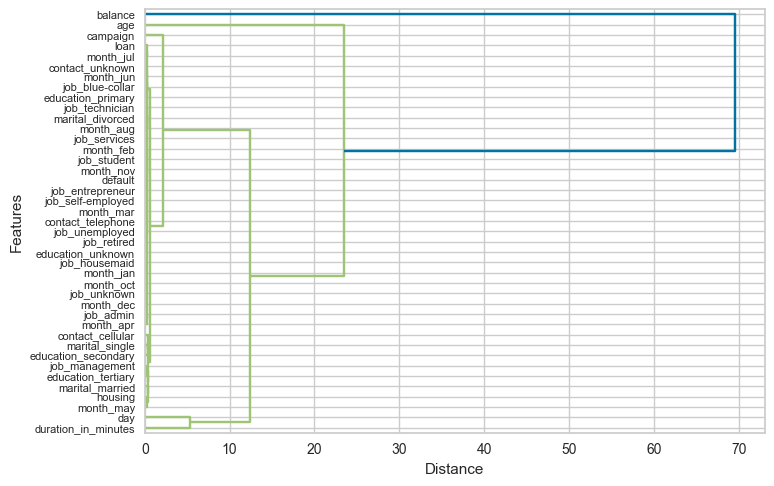

In [628]:
linkage_ = linkage(transposed_df, method='ward', metric='euclidean')
dendrogram(linkage_, labels=numeric_cols, orientation='right', distance_sort='descending', show_leaf_counts=True)
plt.ylabel('Features')
plt.xlabel('Distance')
plt.show()

In [629]:
from sklearn.cluster import KMeans

#################### for reproducability purposes use seed=4928

seed = 4928
# print(seed)

inertia_list=[]
for i in range(1,20):
    kmeans = KMeans(n_clusters=i, random_state=seed)
    kmeans.fit(normalized_df)
    inertia_list.append(kmeans.inertia_)

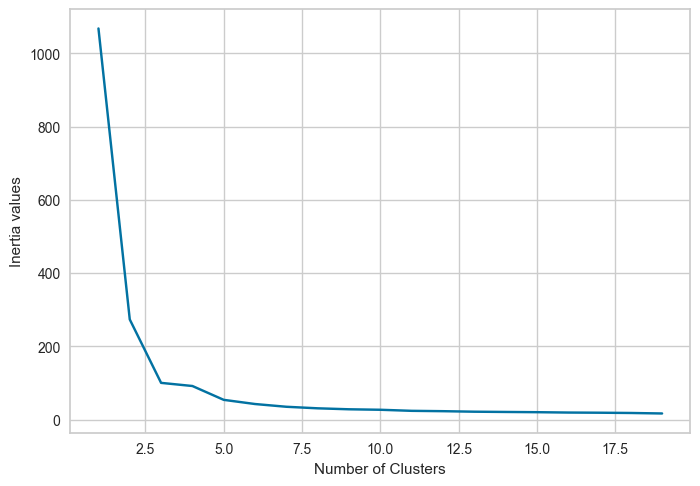

In [630]:
plt.plot(np.arange(1,20), inertia_list)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia values')
plt.show()

In [635]:
non_numeric_cols = [col for col in dummied_X.columns if dummied_X[col].dtype == 'category']
X_ = dummied_X.drop(non_numeric_cols, axis=1)

kmeans = KMeans(n_clusters=3, random_state=seed)
kmeans.fit(X_)
X_['kmeans_label'] = kmeans.labels_
X['kmeans_label'] = kmeans.labels_

kmeans.fit(normalized_df)
normalized_df['kmeans_label'] = kmeans.labels_
print('Shape of normalized dataframe: ', normalized_df.shape)
normalized_df.head()

Shape of normalized dataframe:  (2896, 42)


,age,default,balance,housing,loan,day,campaign,duration_in_minutes,job_admin,job_blue-collar,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,kmeans_label
0,0.113972,0.0,0.989275,0.004559,0.000000,0.082060,0.004559,0.038295,0.0,0.004559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004559,0.0,0.0,0
1,0.007687,0.0,0.999960,0.000197,0.000000,0.002365,0.000197,0.003883,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000197,0.0,0.0,0
2,0.176172,0.0,0.971461,0.005033,0.000000,0.151004,0.005033,0.047399,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
3,0.680443,0.0,0.000000,0.022681,0.022681,0.612399,0.022681,0.397303,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.022681,0.0,0.0,1
4,0.009099,0.0,0.999953,0.000000,0.000000,0.002730,0.000682,0.001638,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0


In [642]:
X['kmeans_label'].value_counts()

kmeans_label
0    2474
1     397
2      25
Name: count, dtype: int64

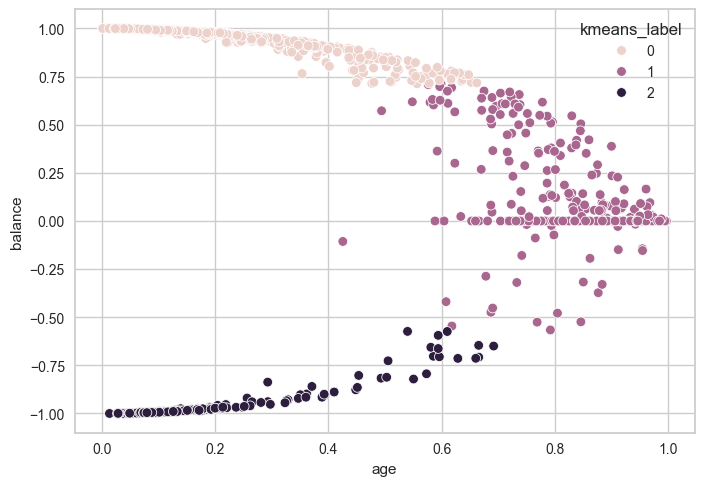

In [643]:
sns.scatterplot(data=normalized_df, x='age', y='balance', hue='kmeans_label')
plt.show()

In [644]:
for i in range(0, len(X['kmeans_label'].unique())):    
    job = X[X['kmeans_label']==i]['job'].value_counts().index[0]
    job_count = round((X[X['kmeans_label']==i]['job'].value_counts()[0]/X[X['kmeans_label']==i]['job'].value_counts().sum()), 3)*100
    education = X[X['kmeans_label']==i]['education'].value_counts().index[0]
    marital = X[X['kmeans_label']==i]['marital'].value_counts().index[0]
    age = X[X['kmeans_label']==i]['age'].median()
    balance = X[X['kmeans_label']==i]['balance'].median()
    print(f"Group {i} has a median age of {age} and a median balance of ${balance}.\n\tThey predominantly have {education} education, have jobs as {job} that make up {job_count}% of their group, and are {marital}.")

Group 0 has a median age of 37.0 and a median balance of $431.5.
	They predominantly have secondary education, have jobs as management that make up 22.1% of their group, and are married.
Group 1 has a median age of 39.0 and a median balance of $5024.0.
	They predominantly have tertiary education, have jobs as management that make up 31.0% of their group, and are married.
Group 2 has a median age of 39.0 and a median balance of $19268.0.
	They predominantly have tertiary education, have jobs as technician that make up 32.0% of their group, and are single.


In [645]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from umap.umap_ import UMAP

pca=PCA(random_state=seed)
tsne=TSNE(random_state=seed, perplexity=50, n_components=3)
umap_=UMAP(random_state=seed)

pca.fit_transform(normalized_df)
tsne_fit = tsne.fit_transform(X_)
# umap_fit = umap_.fit_transform(dummy_new_X)

In [646]:
pca.explained_variance_ratio_.cumsum()

array([0.89031348, 0.97925772, 0.98716989, 0.99419193, 0.99901117,
       0.99959296, 0.99965396, 0.99970585, 0.99974908, 0.99978439,
       0.99980853, 0.9998291 , 0.99984849, 0.99986603, 0.99988068,
       0.99989437, 0.99990668, 0.99991842, 0.99992819, 0.99993745,
       0.99994607, 0.99995381, 0.99996001, 0.99996551, 0.99997045,
       0.99997489, 0.99997884, 0.99998275, 0.99998643, 0.99998954,
       0.99999236, 0.99999435, 0.99999605, 0.99999748, 0.99999855,
       0.99999939, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

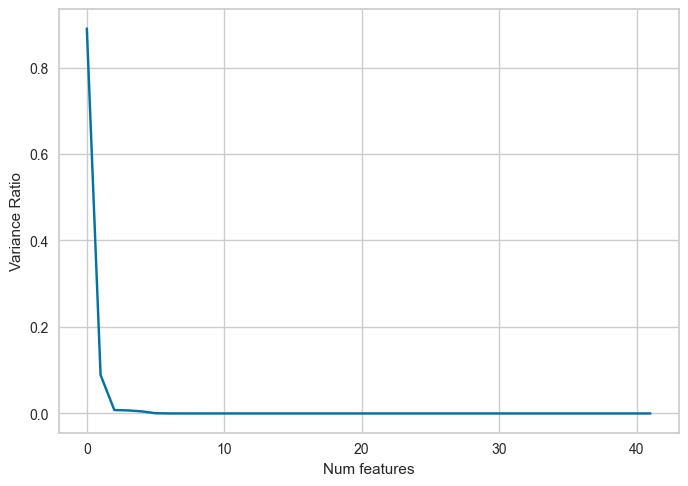

In [647]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Num features')
plt.ylabel('Variance Ratio')
plt.show()

In [648]:
pca = PCA(n_components=3, random_state=seed)
pca_fit = pca.fit_transform(normalized_df)
normalized_df['pca_x'] = pca_fit[:, 0]
normalized_df['pca_y'] = pca_fit[:, 1]
# normalized_df[['pca_x', 'pca_y']].head()

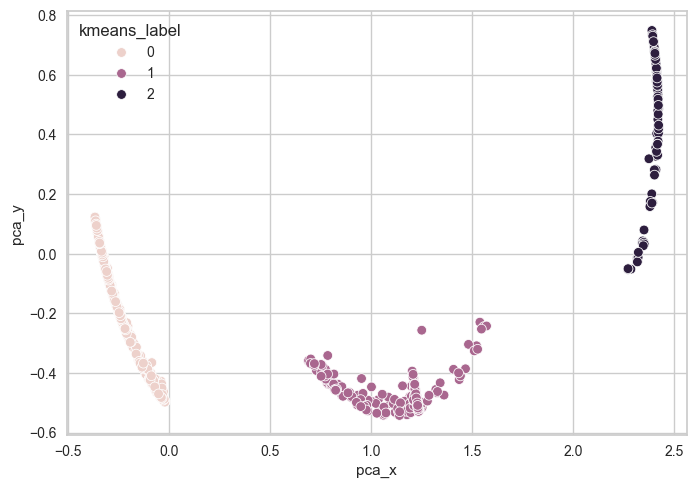

In [649]:
sns.scatterplot(data=normalized_df, x='pca_x', y='pca_y', hue='kmeans_label')
# plt.title('PCA')
plt.show()

In [650]:
X['tsne_x'] = tsne_fit[:, 0]
X['tsne_y'] = tsne_fit[:, 1]
X['tsne_z'] = tsne_fit[:, 2]
# X[['tsne_x', 'tsne_y', 'tsne_z']].head()

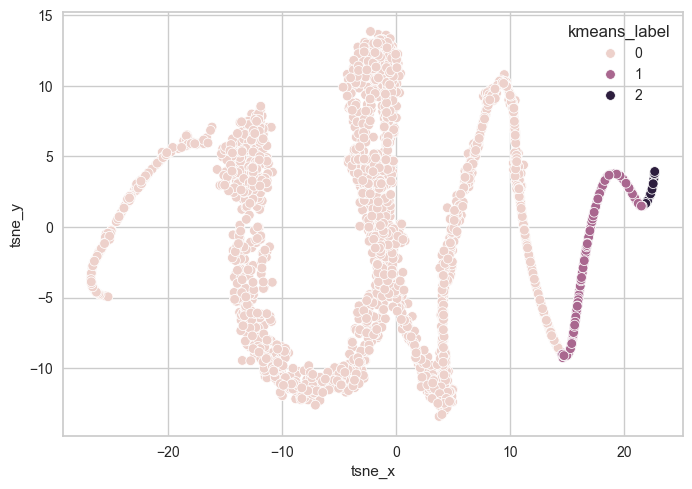

In [651]:
sns.scatterplot(data=X, x='tsne_x', y='tsne_y', hue='kmeans_label')
plt.show()

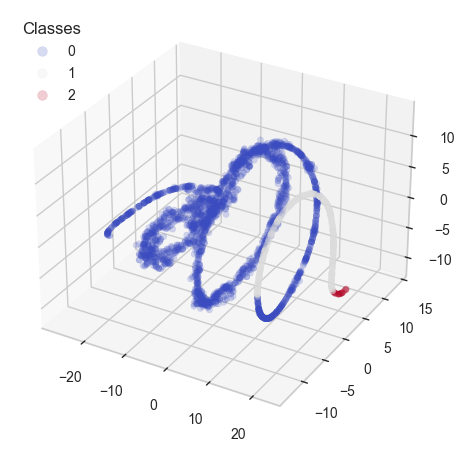

In [652]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X['tsne_x'], X['tsne_y'], X['tsne_z'], c=X['kmeans_label'], alpha=.2, cmap='coolwarm')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
plt.show()

## Conclusion

* The first section's SGDClassifier obtained ~90% recall score for the positive class equating to roughly 130 hours of saved call time.
* The second layer - looking at a mix of recall, precision, true negatives, and f1 macro - saw a LGBMClassifier model obtain a decent precsion score, fairly good recall score, fairly decent f1 macro score and over 6500 true negatives equating to over 330 hours of call time saved.
* Finally, the last section provided a look at the segment of clients that should be prioritized as well as features that make customers subscribe to the product using clustering and dimensionality reduction techniques.
* The main insight from this section was that the KMeans algorithm found 3 clusters that when compared to the categorical features in our original dataset, such as job, education, and marital status, clusters 1 and 2 (if looking at the 3D plot above these are the white and red colors) were found to have tertiary education while the other cluster (blue cluster) had secondary. Management job types were found in clusters 0 and 1 while technician was the job of cluster 2.
* The main segment of customers to prioritize are those customers that have tertiary or secondary education levels and who have technician or managerial jobs. And the thing that makes the customer subscribe is their balance...the higher their balance the more likely they will subscribe.